In [ ]:



from sklearn.metrics import accuracy_score,confusion_matrix
df_imputed=pd.read_csv('merged_file_only_diagnosis.csv')
df_imputed=df_imputed.drop(columns=['Sample'])
print(df_imputed.isna().sum())
variance_threshold = 0.01  # Adjust this threshold as needed
low_variance_columns = df_imputed.columns[df_imputed.var() < variance_threshold]

# Drop low variance columns
df_imputed = df_imputed.drop(columns=low_variance_columns)

# Step 2: Remove highly correlated columns
# Calculate the correlation matrix
correlation_matrix = df_imputed.corr().abs()

# Find pairs of columns with correlation above a certain threshold
correlation_threshold = 0.9  # Adjust this threshold as needed
columns_to_drop = set()

# Loop through the correlation matrix and collect columns to drop
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if correlation_matrix.iloc[i, j] > correlation_threshold:
            colname = correlation_matrix.columns[i]
            columns_to_drop.add(colname)

# Drop the highly correlated columns
df_imputed = df_imputed.drop(columns=columns_to_drop)
df_imputed.to_csv('corr_var_merged_only_diagnosis.csv',index=False)
print(df_imputed.shape)
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel

ID                 0
DIAGNOSIS          0
C0                 0
C2:0               0
C3:0               0
                  ..
LPE(P-18:0)        0
LPE(P-18:1)        0
methyl-CE(18:1)    0
methyl-CE(18:2)    0
methyl-CE(20:4)    0
Length: 604, dtype: int64
(176, 483)


0.5555555555555556


c:\Users\sothr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


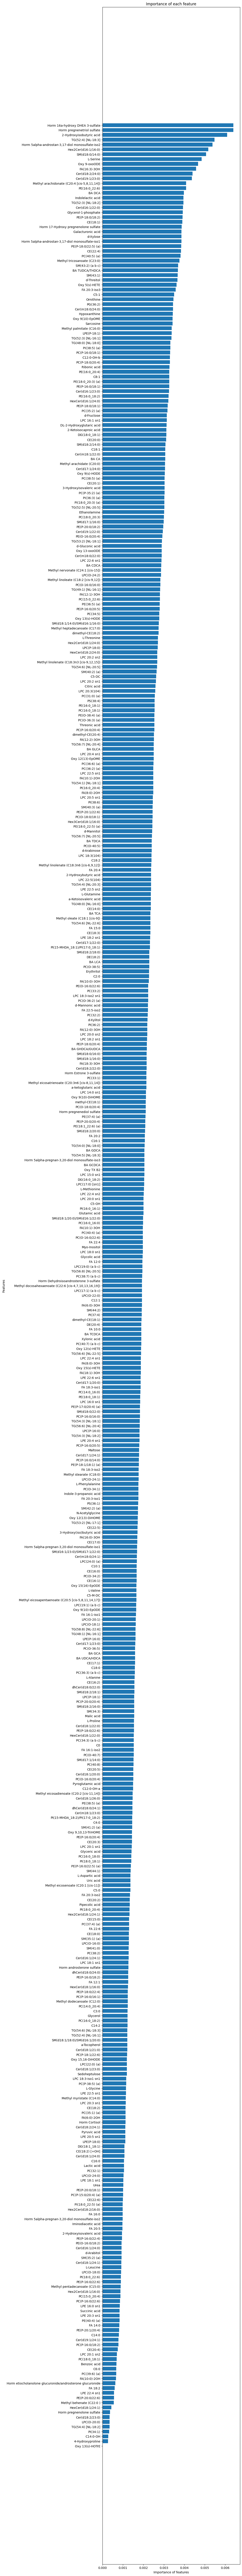

In [2]:
X=df_imputed.drop(columns=['DIAGNOSIS','ID'])
y=df_imputed['DIAGNOSIS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(accuracy_score(y_test, lr.predict(X_test)))
from sklearn.feature_selection import SelectFromModel
func = lr.fit(X_train, y_train)
model = SelectFromModel(func, prefit=True,threshold='mean')
X_new = model.transform(X_train)

# find important features
# ref: http://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X_train, y_train)

imp = model.feature_importances_
names = X.columns

imp, names = zip(*sorted(zip(imp, names)))

%matplotlib inline
plt.figure(1, figsize=(8, 150))

plt.barh(range(len(names)), imp, align = 'center')
plt.yticks(range(len(names)), names)

plt.xlabel('Importance of features')
plt.ylabel('Features')
plt.title('Importance of each feature')
plt.show()

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_imputed = scaler.fit_transform(X_train)
X_test_imputed = scaler.transform(X_test)

# Loop over alpha values from 0.1 to 1 with 0.05 increments
alphas = np.arange(0.4, 1.0, 0.05)

# List to store results
results = []
from sklearn.metrics import f1_score

for alpha in alphas:
    # Create the LogisticRegression model with Elastic Net penalty
    model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=alpha, max_iter=10000)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Get the non-zero coefficients (features selected by Elastic Net)
    non_zero_indices = np.where(model.coef_ != 0)[1]  # Indices of non-zero coefficients
    selected_feature_names = X.columns[non_zero_indices].tolist()
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the F1 score
    f1 = f1_score(y_test, y_pred)
    
    # Store the result for the current alpha
    results.append({
        'alpha': alpha,
        'f1_score': f1,
        'selected_features': selected_feature_names
    })

# Convert the results into a DataFrame for better viewing
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

    alpha  f1_score                                  selected_features
0    0.40  0.250000  [C0, C5-DC, C5:1, C8:1, C12:0-OH-a, Methyl ste...
1    0.45  0.173913  [C5-DC, C5:1, C8:1, Methyl stearate (C18:0), M...
2    0.50  0.173913  [C5-DC, C5:1, C8:1, Methyl stearate (C18:0), M...
3    0.55  0.173913  [C5:1, C8:1, Methyl stearate (C18:0), Methyl a...
4    0.60  0.173913  [C5:1, C8:1, Methyl stearate (C18:0), Methyl a...
5    0.65  0.173913  [C5:1, C8:1, Methyl stearate (C18:0), Methyl a...
6    0.70  0.250000  [C5:1, C8:1, Methyl stearate (C18:0), Methyl a...
7    0.75  0.250000  [C5:1, C8:1, Methyl stearate (C18:0), Methyl a...
8    0.80  0.250000  [C5:1, C8:1, Methyl stearate (C18:0), Methyl a...
9    0.85  0.250000  [C5:1, Methyl stearate (C18:0), Methyl arachid...
10   0.90  0.250000  [C5:1, Methyl stearate (C18:0), Methyl arachid...
11   0.95  0.250000  [C5:1, Methyl stearate (C18:0), Methyl arachid...


In [6]:
results_df.to_csv('results_l1_metabolomics.csv',index=False)

In [7]:
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
df=pd.read_csv('knn5_albion.csv')
print(df)

       ID  SEX  BIRTH_DAY  BIRTH_MONTH  BIRTH_YEAR   Age  VisitNuA   EDU  \
0    4393    2         22           12        1949  69.0         1  12.0   
1    4393    2         22           12        1949  70.0         2  12.0   
2    4393    2         22           12        1949  71.0         3  12.0   
3    4393    2         22           12        1949  73.0         4  12.0   
4    4393    2         22           12        1949  71.6         5  12.0   
..    ...  ...        ...          ...         ...   ...       ...   ...   
579  8547    2         31            8        1982  42.0         1  14.0   
580  8554    1          3           10        1937  51.4         1  17.0   
581  8564    1          2           12        1965  55.0         1  16.0   
582  8575    1          7           10        1976  51.4         1  16.0   
583  8577    1         28           10        1974  55.0         1  18.0   

     MARITAL1   D1  ...  Sugar_Total  Tryptophan    Threonine    Cystine  \
0         3

In [8]:
df1=df.drop(columns=['ID','MCI','MCIME','MCIEX','HAND','MCITYPE','DEMTYPE','DEM','BIRTH_DAY','BIRTH_MONTH','BIRTH_YEAR'])


In [17]:
X=df1.drop(columns=['DIAGNOSIS'])
y=df1['DIAGNOSIS']
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.2, 
                     random_state=0, 
                     stratify=y)
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler


sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)



lr = LogisticRegression(solver='saga', random_state=123,max_iter=20000,penalty='elasticnet',l1_ratio=0.5)
rfe = RFE(estimator=lr, n_features_to_select=10, step=1)
rfe.fit(X_train_std, y_train)
df1.columns[1:][rfe.support_]

Index(['CDR2', 'MEMORY', 'LANGUAGE', 'EXECUTIVE', 'll8cor1', 'EEG_AIG', 'CSF',
       'nEEG', 'zACE_LANGUAGE', 'ZME'],
      dtype='object')

In [20]:
import time
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

model = XGBClassifier(random_state=42)
rfe = RFE(estimator=model, n_features_to_select=10)

# Fit the RFE object with the XGBoost model and the training data
rfe.fit(X_train_std, y_train)

# Train an XGBoost model with all features
start_time = time.perf_counter()
model_all = XGBClassifier(random_state=42)
model_all.fit(X_train_std, y_train)
all_features_time = time.perf_counter() - start_time

# Train an XGBoost model with the selected features from RFE
start_time = time.perf_counter()
model_selected = XGBClassifier(random_state=42)
model_selected.fit(X_train_std[:, rfe.support_], y_train)
selected_features_time = time.perf_counter() - start_time

# Make predictions on the test set with both models
y_pred_all = model_all.predict(X_test_std)
y_pred_selected = model_selected.predict(X_test_std[:, rfe.support_])

# Compare the performance of the models
accuracy_all = accuracy_score(y_test, y_pred_all)
accuracy_selected = accuracy_score(y_test, y_pred_selected)

print(f"Accuracy with all features: {accuracy_all:.4f}")
print(f"Accuracy with selected features: {accuracy_selected:.4f}")
print(f"Training time with all features: {all_features_time:.2f} seconds")
print(f"Training time with selected features: {selected_features_time:.2f} seconds")

c:\Users\sothr\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Accuracy with all features: 0.9316
Accuracy with selected features: 0.9231
Training time with all features: 0.68 seconds
Training time with selected features: 0.13 seconds


In [21]:
df1.columns[1:][rfe.support_]

Index(['CDR2', 'IADL1', 'IADL2', 'MEMORY', 'LANGUAGE', 'EXECUTIVE', 'ACE',
       'MMSE', 'll7cor1', 'll8per1'],
      dtype='object')

In [ ]:
import pandas as pd
df=pd.read_csv('knn5_albion.csv')
df1=df.drop(columns=['ID','MCI','MCIME','MCIEX','HAND','MCITYPE','DEMTYPE','DEM','BIRTH_DAY','BIRTH_MONTH','BIRTH_YEAR'])

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
%matplotlib inline
from sklearn.preprocessing import StandardScaler

# Load data
X=df1.drop(columns=['DIAGNOSIS'])
y=df1['DIAGNOSIS']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)


# Create classifier
lr = LogisticRegression(max_iter=20000)

# Start variables
max_features = np.shape(X_train)[1]
best_score = 0
best_model = ''

# Sequential forward selection
sfs = SFS(lr,
          k_features = (1,max_features), # Select the best feature combination in the range 1 to max_features
          forward = True,
          floating = False,
          scoring = 'accuracy',
          cv = 5,  # Performs stratified k-fold by default.
          n_jobs = -1)
sfs = sfs.fit(X_train.values, y_train) # Use .values because the method can't read DataFrame data structures.

if sfs.k_score_ > best_score:  # To select the best model and visualize the results (DataFrame and plot)
    best_model = sfs
    
print('Sequential forward selection (%i features): ' % np.size(sfs.k_feature_idx_))
print(sfs.k_feature_idx_)
print('CV score: ')
print(sfs.k_score_)
'''

# Sequential backward selection
sbs = SFS(lr, 
          k_features = (1,max_features),
          forward = False, 
          floating = False, 
          scoring = 'accuracy',
          cv = 10, 
          n_jobs = -1)
sbs = sbs.fit(X_train.values, y_train)

if sbs.k_score_ > best_score:
    best_model = sbs

print('Sequential backward selection (%i features): ' % np.size(sbs.k_feature_idx_))
print(sbs.k_feature_idx_)
print('CV score: ')
print(sbs.k_score_)

# Sequential forward floating selection
sffs = SFS(lr, 
           k_features = (1,max_features), 
           forward = True, 
           floating = True, 
           scoring = 'accuracy', 
           cv = 10, 
           n_jobs = -1)
sffs = sffs.fit(X_train.values, y_train)

if sffs.k_score_ > best_score:
    best_model = sffs

print('Sequential forward floating selection (%i features): ' % np.size(sffs.k_feature_idx_))
print(sffs.k_feature_idx_)
print('CV score: ')
print(sffs.k_score_)

# Sequential backward floating selection
sbfs = SFS(lr, 
           k_features = (1,max_features), 
           forward = False,
           floating = True,
           scoring = 'accuracy', 
           cv = 10, 
           n_jobs = -1)
sbfs = sbfs.fit(X_train.values, y_train)

if sbfs.k_score_ > best_score:
    best_model = sbfs

print('Sequential backward floating selection (%i features): ' % np.size(sbfs.k_feature_idx_))
print(sbfs.k_feature_idx_)
print('CV score: ')
print(sbfs.k_score_)

# Visualize results
print('Best model: %s' % best_model)
## Sequential forward floating selection (dataframe)
pd.DataFrame.from_dict(best_model.get_metric_dict()).T

## Sequential forward floating selection (plot)
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(best_model.get_metric_dict(), kind='std_dev')
plt.ylim([0.6,1])
plt.grid()
plt.show()



'''